In [3]:
import pyart
import numpy as np
import matplotlib.pyplot as plt
from vcor_dual_prf import correct_dualprf
from vel_correction import staggered_to_dual, smooth_vel


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/home/viper/miniconda3/envs/py39/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### CORRECTING THE CATASTROPHIC ERRORS IN RADIAL VELOCITY

Due to the Doppler dilemma which states that the maximum unambiguous velocity can be increased only at the expense of the reduction of maximum unambiguous range, some techniques were developed in order to circumvent this constraint in Doppler weather radars. Among these is the staggered PRT technique which was first proposed by Sirmans et al. (1976) and later by Zrnic and Mahapatra (1985). This technique makes use of alternating pulse repetition times (henceforth PRT) $T_{1}$ and $T_{2}$, where $T_{1}<T_{2}$ in order to achieve an extended maximum unambiguous velocity interval, without the need to reduce de maximum unambiguous range. PRTs are picked such that $T_{1}$ and $T_{2}$ are prime integers, where $K = T_{1}/T_{2} = m/n$ is the PRT ratio, and $K$ is usually 1/2, 2/3, 3/4, or 4/5.
#### Similar procedure but for the single-pol Manaus radar
As shown by Torres et al. (2004), radial velocities aliase at different intervals for each of the PRTs, and, therefore, radial velocities estimated from $T_{2}$ can be used to dealiase velocity stimates from $T_{1}$ following a set of predetermined dealiasing rules which I'm not going to delve into (see Torres et al. 2004 for more info). However, some considerations must be taken into accout when using this technique. First of, as shown by Zrnic and Mahapatra (1985), the variance of radial velocities is inversely proportional to the difference between $T_{1}$ and $T_{2}$, and if $K\rightarrow 1$, the statistical fluctuations may be too large and the quality of velocity estimates will be significantly degraded. Hence, the dealiasing algorithm will unfold the a bad velocity estimate using the wrong rule yelding a completely incorrect velocity value also known as a "catastrophic error". However, it's possible to reduce the amount of catastrophic errors by reducing the ratio $K$, with 2/3 being a good choice as shown in the literature (e.g., Sachidananda and Zrnic 2000, 2002; Torres et al. 2004; Sachidananda and Zrnic 2006). Albeit it will sligthly decrease the maximum extended unambiguous velocity, areas of velocity folding will still be limited to the most extreme cases. However, areas of high azimuthal shear and turbulence will still be marked such errors as the variance between velocity stimates can still be high.

During my undergrad and master's degrees I worked with brazillian radars which make use of the staggered PRT. However, most of our radars make use PRT ratios of 3/4 or 4/5. This was a tremenduous headache to work with, especially when working with severe thunderstoms. Luckily, with hints from professor Stephen Nesbitt from UIUC, I figured a way of correcting most of these errors using circular statistics by adapting the algorithms developed by Altube et al. (2017) and Hengstbeck et al. (2018) for radar implementing the dual-PRF technique. These algorithms can be downloaded in the Meteo Catalunya repository (https://github.com/meteocat/vcor_dual_prf). You will need to clone this repository and copy the vcor_dual_prf.py script on your working directiory. All files including the sample radar volume can be found in the github repository that I have created (https://github.com/Soudaaa/correct_catastrophic_errors)

#### References:

<div class="csl-entry">Altube, P., Bech, J., Argemí, O., Rigo, T., Pineda, N., Collis, S., and Helmus, J. (2017). Correction of dual-PRF Doppler Velocity Outliers in the Presence of Aliasing. <i>Journal of Atmospheric and Oceanic Technology</i>, <b>34</b>, 1529–1543.

<div class="csl-entry">Hengstebeck, T., Wapler, K., Heizenreder, D., and Joe, P. (2018). Radar network-based detection of mesocyclones at the German Weather Service. <i>Journal of Atmospheric and Oceanic Technology</i>, <b>35</b>, 299–321.</div>

<div class="csl-entry">Torres, S. M., Dubel, Y. F., and Zrnić, D. S. (2004). Design, Implementation, and Demonstration of a Staggered PRT Algorithm for the WSR-88D. <i>Journal of Atmospheric and Oceanic Technology</i>, <b>21</b>, 1389–1399.</div>

<div class="csl-entry">Sachidananda, M., and Zrnić, D. S. (2000). Clutter Filtering and Spectral Moment Estimation for Doppler Weather Radars Using Staggered Pulse Repetition Time (PRT). <i>Journal of Atmospheric and Oceanic Technology</i>, <b>17</b>, 323–331.</div>

<div class="csl-entry">Sachidananda, M., and Zrnić, D. S. (2002). An Improved Clutter Filtering and Spectral Moment Estimation Algorithm for Staggered PRT Sequences. <i>Journal of Atmospheric and Oceanic Technology</i>, <b>19</b>, 2009–2019.</div>

<div class="csl-entry">Sirmans, D., D. Zrnic, and B. Bumgarner, 1976: Extension of maximum unambiguous Doppler velocity by use of two sampling rates. <i>Preprints 17th Conference on Radar Meteorology</i>, Seattle, WA, Amer. Meteor. Soc., pp. 23-28.

<div class="csl-entry">Zrnić, D. S., and Mahapatra, P. (1985). Two Methods of Ambiguity Resolution in Pulse Doppler Weather Radars. <i>IEEE Transactions on Aerospace and Electronic Systems</i>, <b>21</b>(4), 470–483.</div>

#### Similar procedure but for the single-pol Manaus radar

To make things simpler, I have already created functions that perform the above operations.
Data from this radar doesn't has the correct nyquist interval. Thus, we also have to recalculate it in advance.

Let's run it!

In [4]:
radar = pyart.aux_io.read_gamic('/mnt/d/radar/CISEMPAM/1113/2019-11-13_2224.mvol')

In [5]:
staggered_to_dual(radar)

Let's check if everything is ok

In [6]:
radar.instrument_parameters['prt_mode']

{'comments': 'Pulsing mode Options are: "fixed", "staggered", "dual". Assumed "fixed" if missing.',
 'meta_group': 'instrument_parameters',
 'long_name': 'Pulsing mode',
 'units': 'unitless',
 'data': array([b'dual', b'dual', b'dual', b'dual', b'dual', b'dual', b'dual',
        b'dual', b'dual', b'dual', b'dual', b'dual', b'dual', b'dual',
        b'dual', b'dual', b'dual'], dtype='|S5')}

In [7]:
radar.instrument_parameters['nyquist_velocity']

{'units': 'meters_per_second',
 'comments': 'Unambiguous velocity',
 'meta_group': 'instrument_parameters',
 'long_name': 'Nyquist velocity',
 'data': array([31.071497, 31.071497, 31.071497, ..., 31.071497, 31.071497,
        31.071497], dtype=float32)}

In [8]:
radar.instrument_parameters['prt_ratio']

{'units': 'unitless',
 'meta_group': 'instrument_parameters',
 'long_name': 'Pulse repetition frequency ratio',
 'data': array([1.5, 1.5, 1.5, ..., 1.5, 1.5, 1.5], dtype=float32)}

In [9]:
radar.instrument_parameters['prf_flag']

{'units': 'unitless',
 'comments': 'PRF used to collect ray. 0 for high PRF, 1 for low PRF.',
 'meta_group': 'instrument_parameters',
 'long_name': 'PRF flag',
 'data': array([0, 1, 0, ..., 1, 0, 1])}

In [10]:
correct_dualprf(radar=radar, two_step=True,
                     method_det='cmean', kernel_det=np.ones((11, 11)),
                     method_cor='cmean', kernel_cor=np.ones((5, 5)),
                     vel_field='corrected_velocity', new_field='vcor_cmean', replace=True)

radar.fields['vcor_cmean']['units'] = 'meters_per_second'
radar.fields['vcor_cmean']['standard_name'] = 'corrected_radial_velocity_of_scatterers_away_from_instrument'
radar.fields['vcor_cmean']['long_name'] = 'Corrected mean doppler velocity'
radar.fields['vcor_cmean']['coordinates'] = 'elevation azimuth range'

smooth_vel(radar, vel_name = 'vcor_cmean')

/home/viper/CENSIPAM/vcor_dual_prf.py:234: RuntimeWarning: invalid value encountered in divide
  avg_ma = np.ma.array(data=sum_arr/valid_num, mask=mask)


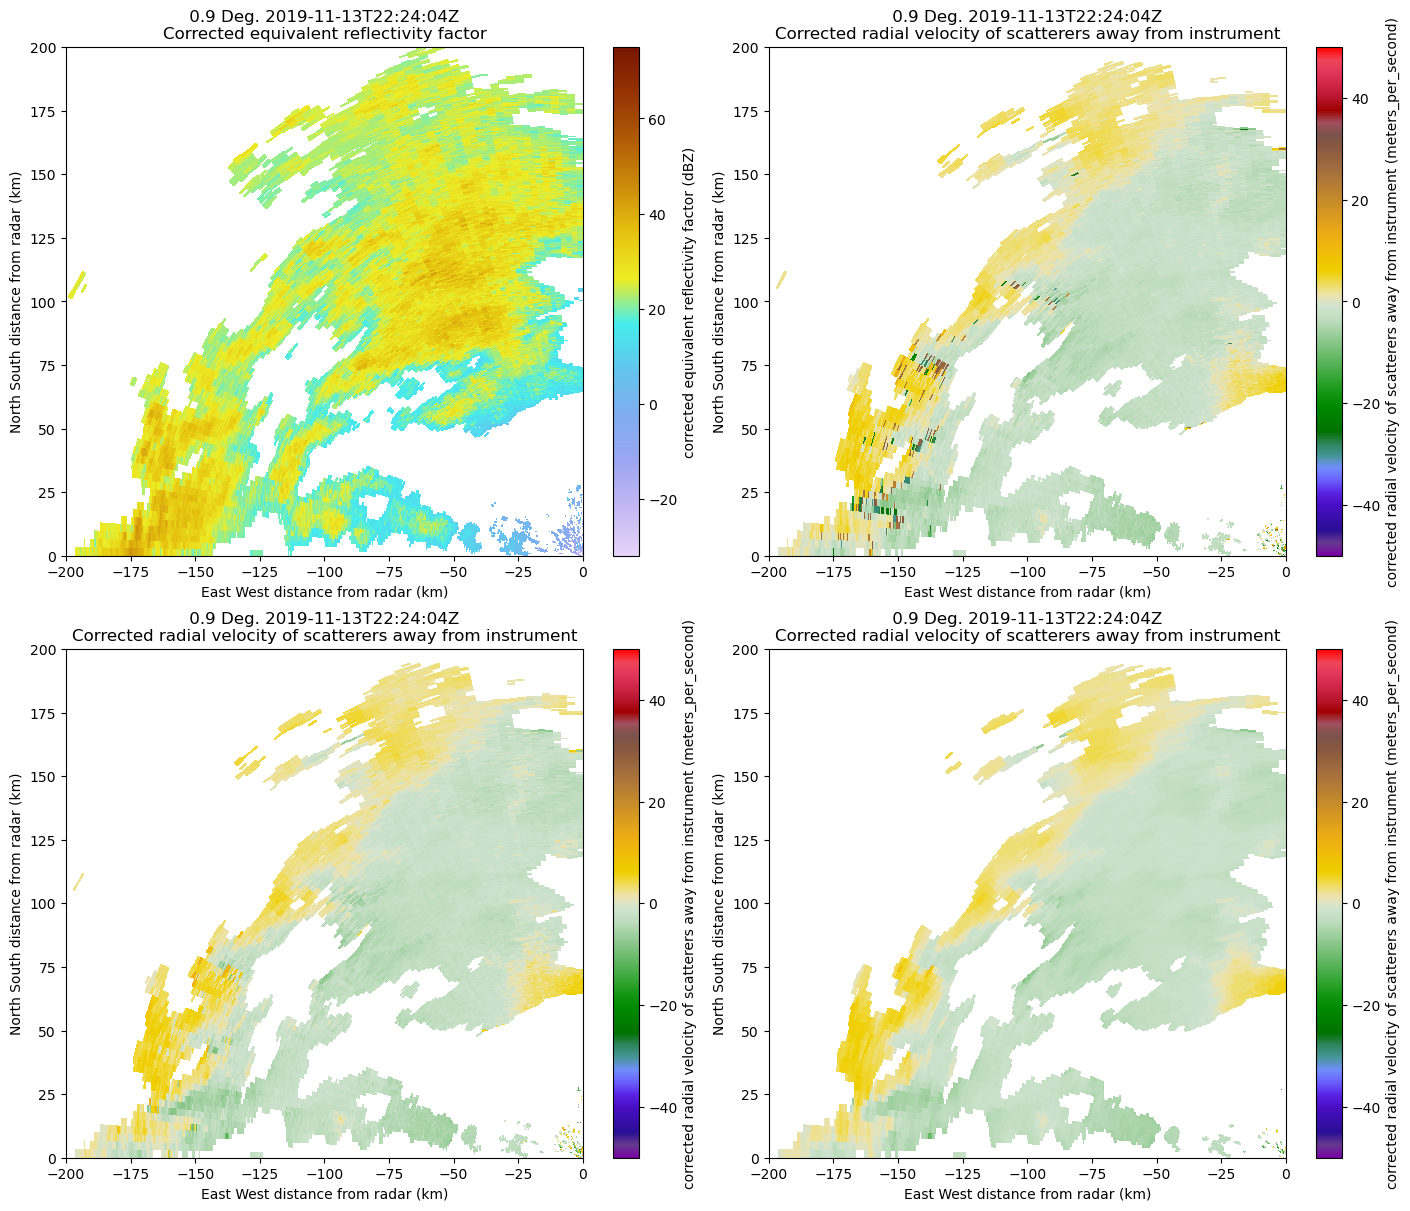

In [11]:
fig, axs = plt.subplots(2, 2, figsize = [14, 12], constrained_layout = True)

for ax in axs.ravel():
    ax.set_xlim(-200, 0)
    ax.set_ylim(0, 200)

display = pyart.graph.RadarDisplay(radar)
display.plot_ppi('corrected_reflectivity', 0, vmin = -32, vmax = 75, cmap = pyart.graph.cm.LangRainbow12, ax = axs.ravel()[0])
display.plot_ppi('corrected_velocity', 0, vmin = -50, vmax = 50, cmap = pyart.graph.cm.Carbone42, ax = axs.ravel()[1])
display.plot_ppi('vcor_cmean', 0, vmin = -50, vmax = 50, cmap = pyart.graph.cm.Carbone42, ax = axs.ravel()[2])
display.plot_ppi('vcor_cmean_smooth', 0, vmin = -50, vmax = 50, cmap = pyart.graph.cm.Carbone42, ax = axs.ravel()[3])